In [130]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, TimeSeriesSplit

import lightgbm as lgb
import catboost as cb

from tsfresh.examples import load_robot_execution_failures
from tsfresh import extract_features, select_features
import optuna

from common import EP
from dfdb import DFDB

import numpy as np
from sklearn.decomposition import PCA

import types
import copy
import datetime
from IPython.lib import kernel

import numpy as np
from sklearn.manifold import TSNE


In [2]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [3]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_colwidth', -1)

In [4]:
df_train = pd.read_pickle('../feats/df_train.pkl')
df_test = pd.read_pickle('../feats/df_test.pkl')

df_train['label'] = df_train['y'].apply(lambda x:  int(x) if x<15 else 15)
group = df_train['season'].values
group[np.where(group==17)[0]] = 1
df_train['group'] = group
df_train = df_train.drop(columns=['season'])

In [5]:
df_spec_train = pd.read_pickle('../feats/spec_features.pkl')
df_spec_test = pd.read_pickle('../feats/spec_features_test.pkl')

In [6]:
df_train = pd.merge(df_train, df_spec_train, on='index')
df_test = pd.merge(df_test, df_spec_test, on='index')

In [7]:
test_X = df_train.drop(columns=['y','index','group','label']).copy()
test_X.index = df_train['index']
test_y = df_train['y'].copy()
test_y.index = df_train['index']
tsfresh_columns = select_features(test_X, test_y).columns.tolist()

In [8]:
len(tsfresh_columns)

9731

In [9]:
top200 =['spkt_welch_densitycoeff_2',
 'spkt_welch_density__coeff_3',
 'q25_roll_std_100',
 '3th_peak_freq',
 'min_roll_std_100',
 'q05_roll_std_100',
 'iqr_6',
 'abs_max_8',
 'mfcc_5_abs_mean',
 "number_peaks{'n': 10}",
 'ave10_7',
 'mfcc_13_mean',
 "autocorrelation{'lag': 5}",
 'mfcc_accelerate_8_variance',
 'abs_max_7',
 'mfcc_accelerate_1_kurtosis',
 'q05_roll_std_1000',
 'spkt_welch_density__coeff_42',
 'max_to_min_diff_5',
 'mfcc_13_quantile25',
 'fft_coefficientcoeff_80__attr_"imag"',
 'abs_q25_5',
 'mfcc_5_mean',
 'median__roll_std',
 '5000skewness_max_',
 'fft_coefficientcoeff_6__attr_"abs"',
 'partial_autocorrelationlag_5',
 'abs_min_8',
 'spkt_welch_density__coeff_28',
 'ar_coefficientk_10__coeff_3',
 'abs_q75_7',
 'mfcc_accelerate_15_min',
 'abs_max_4',
 'mfcc_10_quantile25',
 "change_quantiles{'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'}",
 'spkt_welch_density__coeff_79',
 "value_count{'value': 1}",
 '5000peak_peak_amp_max_',
 'min__roll_std',
 'mfcc_4_rolling_std_mean',
 'q01_roll_std_1000',
 'mfcc_3_abs_q75',
 'mfcc_5_quantile95',
 'fft_coefficientcoeff_16__attr_"imag"',
 'abs_q01_4',
 'mfcc_6_quantile05',
 'agg_autocorrelationf_agg_"mean"__maxlag_40',
 '5000quantile25skewness_',
 'mfcc_0_abs_q25',
 'mfcc_delta_3_quantile01',
 'spkt_welch_density__coeff_99',
 'mfcc_9_mean',
 'mfcc_12_mean',
 'q75_roll_mean_10',
 'max_to_min',
 'mfcc_3_abs_mean',
 'kurt_7',
 'mfcc_14_quantile01',
 'mfcc_10_mean',
 'mfcc_delta_13_min',
 'mfcc_delta_13_abs_max',
 '5000no_zero_crossing_mean_',
 'abs_q75_6',
 'mfcc_12_quantile99',
 'mfcc_accelerate_6_skewness',
 'mfcc_5_max',
 '5000smoothness_entropy_',
 '5000median_skewness_',
 'mfcc_accelerate_8_min',
 'abs_min_3',
 '5000quantile75mean_',
 "number_crossing_m{'m': 1}",
 '5000smoothness_std_',
 'mfcc_9_abs_q25',
 'flac3_1_quantile99',
 'mfcc_5_skewness',
 'fft_coefficientcoeff_56__attr_"angle"',
 'fft_coefficientcoeff_70__attr_"abs"',
 'mfcc_10_abs_q75',
 'fft_coefficientcoeff_24__attr_"angle"',
 'med_7',
 'spkt_welch_density__coeff_73',
 'abs_q99_8',
 'ave10_6',
 'spkt_welch_density__coeff_38',
 'skew_1',
 'mfcc_delta_3_abs_q95',
 "change_quantiles{'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}",
 'max_to_min_5',
 'mfcc_delta_4_quantile75',
 'abs_max_1',
 '5000crest_factor_quantile75',
 'partial_autocorrelationlag_1',
 'mfcc_delta_11_quantile01',
 'mfcc_accelerate_7_quantile01',
 'mfcc_8_rolling_std_mean',
 'q95_roll_mean_100',
 'mfcc_delta_6_rolling_std_mean',
 'flac3_0_min',
 'fft_coefficientcoeff_36__attr_"abs"',
 'iqr_8',
 'max_9',
 '5000smoothness_quantile05',
 'mfcc_1_kurtosis',
 'mfcc_7_abs_q95',
 'spkt_welch_density__coeff_66',
 'spkt_welch_density__coeff_64',
 'mfcc_3_abs_q95',
 '5000skewness_mean_',
 'mfcc_10_abs_mean',
 '5000quantile99quantile01',
 'mean_change_rate',
 'mfcc_accelerate_5_rolling_std_mean',
 'mfcc_accelerate_5_quantile05',
 '5000rms_median_',
 'flac3_1_abs_mean',
 '5000rms_quantile05',
 '5000quantile75quantile25',
 'mfcc_accelerate_12_min',
 "value_count{'value': -1}",
 'mfcc_12_abs_max',
 'abs_min_5',
 'mfcc_5_abs_q99',
 'mfcc_delta_5_quantile01',
 'mfcc_12_quantile75',
 'fft_coefficientcoeff_56__attr_"imag"',
 'spkt_welch_densitycoeff_5',
 'mfcc_0_abs_q05',
 'mfcc_13_quantile75',
 'mfcc_delta_5_min',
 'mfcc_5_quantile99',
 'fft_coefficientcoeff_8__attr_"angle"',
 'spkt_welch_density__coeff_30',
 'mfcc_accelerate_4_max',
 'mfcc_14_median',
 "change_quantiles{'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'}",
 'mfcc_5_median',
 'mfcc_accelerate_5_abs_q75',
 'spkt_welch_density__coeff_59',
 'mfcc_accelerate_5_kurtosis',
 'mfcc_delta_9_quantile99',
 'mfcc_5_quantile25',
 'spkt_welch_density__coeff_113',
 'mfcc_2_quantile05',
 'spkt_welch_density__coeff_58',
 'mfcc_5_abs_q75',
 'spkt_welch_density__coeff_22',
 'spkt_welch_density__coeff_115',
 'spkt_welch_density__coeff_4',
 'mfcc_5_abs_q05',
 'spkt_welch_density__coeff_25',
 'mfcc_5_abs_max',
 'spkt_welch_density__coeff_27',
 'mfcc_4_quantile75',
 'mfcc_3_rolling_std_mean',
 'mfcc_4_median',
 'mfcc_0_quantile01',
 '5000quantile75rssq_',
 'fft_coefficientcoeff_24__attr_"imag"',
 'mfcc_delta_12_kurtosis',
 '5000rms_quantile25',
 'mfcc_13_quantile05',
 'fft_coefficientcoeff_8__attr_"imag"',
 'mfcc_delta_11_rolling_std_mean',
 'mfcc_delta_12_quantile99',
 'mfcc_accelerate_9_abs_q25',
 'mfcc_11_abs_mean',
 'mfcc_delta_15_abs_max',
 'abs_max_2',
 'mfcc_11_abs_std',
 'abs_max_roll_mean_1000',
 'peak_to_average_power_ratio__roll_mean',
 'mfcc_13_median',
 'fft_coefficientcoeff_62__attr_"abs"',
 'mfcc_11_quantile75',
 "quantile{'q': 0.8}",
 'mfcc_delta_3_rolling_std_mean',
 'abs_q99_7',
 'mfcc_delta_12_max',
 'mfcc_12_min',
 'mfcc_10_quantile99',
 'mfcc_14_abs_q99',
 'mfcc_14_quantile05',
 'mfcc_14_quantile25',
 'kurt_1',
 'mfcc_2_median',
 'q01_2',
 'mfcc_2_abs_q25',
 'kurt_8',
 'mfcc_accelerate_6_abs_max',
 'mfcc_1_quantile75',
 'q05_5',
 'abs_q95_9',
 'q05_roll_mean_100',
 'mfcc_10_abs_q25',
 'q75_9',
 'mfcc_15_mean',
 "change_quantiles{'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'}",
 'flac3_0_abs_std',
 "change_quantiles{'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'}"]

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

def mdf_lineplot(dflist, plot_features=None, n_col=3):

    
    n_chart = len(dflist)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else n_row+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, df in enumerate(dflist):
        ax = fig.add_subplot(n_row, n_col, i+1)
        if type(plot_features) == type(None):
            plot_features = df.columns.tolist()
        for feat in plot_features:
            sns.lineplot(x=df.index, y=df[feat], ax=ax)
    return 


def mcol_lineplot(df, plot_features=None, n_col=3):

    if type(plot_features)==type(None):
        n_chart = len(df.columns)
        plot_features = df.columns.tolist()
    else:
        n_chart = len(plot_features)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else int(n_chart/n_col)+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, col in enumerate(plot_features):
        ax = fig.add_subplot(n_row, n_col, i+1)
        sns.lineplot(x=df.index, y=col, ax=ax, data=df)
    return 

def mcol_lineplot2(df, plot_features, n_col=3):

    n_chart = len(plot_features)
    n_row = int(n_chart/n_col) if n_chart % n_col == 0 else int(n_chart/n_col)+1
        
    fig = plt.figure(figsize=(5*n_col, 3*n_row))
    for i, base_col in enumerate(plot_features):
        ax = fig.add_subplot(n_row, n_col, i+1)
        for col in df.columns.tolist():
            if base_col in col:
                sns.lineplot(x=df.index, y=col, ax=ax, data=df)
    return 

In [105]:
import numpy as np
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from tensorflow.python.framework import graph_util
import os

class VariationalAE(object):

    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.

    This implementation uses probabilistic encoders and decoders using Gaussian
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.

    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """

    def __init__(self, X_dim, latent_dim, encoder_hidden_layer_sizes, decoder_hidden_layer_sizes, 
                 hidden_layer_activation_function, output_activation_function, kl_coef, drop_out, learning_rate, 
                 batch_size, epochs, random_state=0, **kwargs):
        
        
        self.X_dim = X_dim
        self.latent_dim = latent_dim
        self.encoder_hidden_layer_sizes = encoder_hidden_layer_sizes
        self.decoder_hidden_layer_sizes = decoder_hidden_layer_sizes
        
        if hidden_layer_activation_function == 'relu' or hidden_layer_activation_function == 'RELU':
            self.hidden_layer_activation_function = tf.nn.relu
        elif hidden_layer_activation_function == 'sigmoid' or hidden_layer_activation_function == 'SIGMOID':
            self.hidden_layer_activation_function = tf.nn.sigmoid
        elif hidden_layer_activation_function == 'tanh' or hidden_layer_activation_function == 'TANH':
            self.hidden_layer_activation_function = tf.nn.tanh
        else:
            raise Exception('unknow activation function name')
        
            
        if output_activation_function == 'relu' or output_activation_function == 'RELU':
            self.output_activation_function = tf.nn.relu
        elif output_activation_function == 'sigmoid' or output_activation_function == 'SIGMOID':
            self.output_activation_function = tf.nn.sigmoid
        elif output_activation_function == 'tanh' or output_activation_function == 'TANH':
            self.output_activation_function = tf.nn.tanh
        elif output_activation_function == 'softplus' or output_activation_function == 'SOFTPLUS':
            self.output_activation_function = tf.nn.softplus
        elif output_activation_function == 'softmax' or output_activation_function == 'SOFTMAX':
            self.output_activation_function = tf.nn.softmax
        else:
            raise Exception('unknow activation function name')
            
        self.kl_coef = kl_coef
        self.drop_out = drop_out
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.random_state = random_state
        self.is_training = False
        
        tf.set_random_seed(random_state)
        tf.reset_default_graph()
        self.build_graph()
        self.compile_graph()
        self.sess = tf.InteractiveSession()
        self.sess.run([tf.local_variables_initializer(), tf.global_variables_initializer(),])
        
        return


    def fit(self, X, X_val=None, **kwargs):
        
        his = []
        # Training
        n_sample = X.shape[0]
        n_steps = int(self.epochs*n_sample/self.batch_size)
        # input_queue = tf.train.slice_input_producer([X], shuffle=False, num_epochs=self.epochs)
        batch_X = tf.train.batch([X], batch_size=self.batch_size, enqueue_many=True)

        # self.sess.run([
        #     tf.local_variables_initializer(),
        #     tf.global_variables_initializer(),
        # ])
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=self.sess, coord=coord)

        try:
            # in most cases coord.should_stop() will return True
            # when there are no more samples to read
            # if num_epochs=0 then it will run for ever
            index = 1
            while not coord.should_stop():
                # will start reading, working data from input queue
                # and "fetch" the results of the computation graph
                # into raw_images and raw_labels
                batch_x = self.sess.run(batch_X)
                self.is_training = True
                self.sess.run((self.train_op), feed_dict={self.x: batch_x, self.keep_prob: 1 - self.drop_out})
                if (index % int(n_sample / self.batch_size) == 0):
                    d_ = {}
                    self.is_training = False
                    mse, loss, kle, reconstructione = self.sess.run((self.mse, self.loss, self.kle, self.reconstructione),feed_dict={self.x: X, self.keep_prob: 1.0})
                    d_ = {'loss': loss,'kle': kle, 'reconstructione': reconstructione, 'mse': mse}
                    if type(X_val)!=type(None):
                        val_mse, val_loss, val_kle, val_reconstructione = self.sess.run((self.mse, self.loss, self.kle, self.reconstructione),feed_dict={self.x: X_val, self.keep_prob: 1.0})
                        d_ = {'val_loss': val_loss,'val_kle': val_kle, 'val_reconstructione': val_reconstructione, 'val_mse': val_mse, **d_}
                    his.append(d_)    
                    
                index = index + 1
                if index == n_steps+1:
                    coord.request_stop()
        finally:
            coord.request_stop()
            coord.join(threads)

        return his

    def scores(self, X, **kwargs):
        his = []
        for _x in X:
            self.is_training = False
            mse, loss, kle, reconstructione = self.sess.run(
                (self.mse, self.loss, self.kle, self.reconstructione),
                feed_dict={self.x: [_x], self.keep_prob: 1.0})
            # print('epoch loss', loss)
            his.append(
                {'loss': loss,
                 'kle': kle,
                 'reconstructione': reconstructione,
                 'mse': mse})
        return his
    
        # latent
    def transform(self, X):
        latent_list = []
        for _x in X:
            latent_list.append(self.z.eval(session=self.sess, feed_dict={self.x: [_x], self.keep_prob: 1.0}))
        latent_array = np.array(latent_list)
        return latent_array

    # out put
    def predict(self, X):
        output_list = []
        for _x in X:
            output_list.append(self.y.eval(session=self.sess, feed_dict={self.x: [_x], self.keep_prob: 1.0}))
        output_array = np.array(output_list)
        return output_array

    # Gaussian MLP as encoder
    def _build_encoder(self):
        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        x_ = self.x
        input_dim = self.X_dim
        for index, unit in enumerate(self.encoder_hidden_layer_sizes):
            # 1st hidden layer
            w_variable_name_ = 'encoder_w{:d}'.format(index)
            b_variable_name_ = 'encoder_b{:d}'.format(index)
            w = tf.get_variable(w_variable_name_, [input_dim, unit], initializer=w_init)
            b = tf.get_variable(b_variable_name_, [unit], initializer=b_init)
            x_ = tf.matmul(x_, w) + b
            x_ = tf.layers.batch_normalization(x_, training=self.is_training)
            x_ = self.hidden_layer_activation_function(x_)
            x_ = tf.nn.dropout(x_, self.keep_prob)
            input_dim = unit

        # output layer
        wo = tf.get_variable('encoder_wo',[unit, self.latent_dim * 2], initializer=w_init)
        bo = tf.get_variable('encoder_bo',[self.latent_dim * 2], initializer=b_init)
        gaussian_params = tf.matmul(x_, wo) + bo
        gaussian_params = tf.layers.batch_normalization(gaussian_params, training=self.is_training)

        # The mean parameter is unconstrained
        self.mu = gaussian_params[:, :self.latent_dim]
        # The standard deviation must be positive. Parametrize with a softplus and
        # add a small epsilon for numerical stability
        self.sigma = 1e-6 + tf.nn.softplus(gaussian_params[:, self.latent_dim:])

        # sampling by re-parameterization technique
        eps = tf.random_normal(tf.shape(self.mu), mean=0, stddev=1)
        self.z = self.mu + self.sigma * eps


    # Bernoulli MLP as decoder
    def _build_decoder(self):

        # initializers
        w_init = tf.contrib.layers.variance_scaling_initializer()
        b_init = tf.constant_initializer(0.)

        x_ = self.z
        input_dim = self.latent_dim
        for index, unit in enumerate(self.decoder_hidden_layer_sizes):
            # 1st hidden layer
            w_variable_name_ = 'decoder_w{:d}'.format(index)
            b_variable_name_ = 'decoder_b{:d}'.format(index)
            w = tf.get_variable(w_variable_name_, [input_dim, unit], initializer=w_init)
            b = tf.get_variable(b_variable_name_, [unit], initializer=b_init)
            x_ = tf.matmul(x_, w) + b
            x_ = tf.layers.batch_normalization(x_, training=self.is_training)
            x_ = self.hidden_layer_activation_function(x_)
            x_ = tf.nn.dropout(x_, self.keep_prob)
            input_dim = unit

        # output layer-mean
        wo = tf.get_variable('decoder_wo',[unit, self.X_dim], initializer=w_init)
        bo = tf.get_variable('decoder_bo',[self.X_dim], initializer=b_init)
        params = tf.matmul(x_, wo) + bo
        params = tf.layers.batch_normalization(params, training=self.is_training)
        self.y = self.output_activation_function(params, name='output')

        return

    def _loss(self):

        local_epsilon = 1e-6
        # marginal_likelihood = self.x * tf.log(tf.clip_by_value(self.y, local_epsilon, 1.0)) + \
        #                             (1 - self.x) * tf.log(tf.clip_by_value(1 - self.y, local_epsilon, 1.0))
        y_ = tf.clip_by_value(self.y, local_epsilon, 1 - local_epsilon)
        x_ = tf.clip_by_value(self.x, local_epsilon, 1 - local_epsilon)
        marginal_likelihood = x_ * tf.log(y_) + (1 - x_) * tf.log(1 - y_)
        marginal_likelihood = -1 * tf.reduce_sum(marginal_likelihood, 1)

        mu_ = tf.clip_by_value(self.mu, local_epsilon, 1 - local_epsilon)
        sigma_ = tf.clip_by_value(self.sigma, local_epsilon, 1 - local_epsilon)
        kl_divergence = 1 + tf.log(tf.square(sigma_)) - tf.square(mu_) - tf.square(sigma_)
        kl_divergence = -self.kl_coef * tf.reduce_sum(kl_divergence, 1)

        self.loss = tf.reduce_mean(marginal_likelihood + kl_divergence, name='loss')
        self.mse = tf.sqrt(tf.losses.mean_squared_error(self.y, self.x), name='mse')
        self.kle = tf.reduce_mean(kl_divergence, name='kle')
        self.reconstructione = tf.reduce_mean(marginal_likelihood, name='reconstructione')
        return


    def compile_graph(self):
        
        # loss
        self._loss()
        # train
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        return

    def build_graph(self):

        self.keep_prob = tf.placeholder(tf.float32, name="keep_prob")
        self.x = tf.placeholder(tf.float32, [None, self.X_dim], name='input')
        # encoding
        self._build_encoder()
        # decoding
        self._build_decoder()
        return


In [224]:
def process(df_train, param, df_test=None, trial=None, remark=None):



        # stratified,group,timeseries
        if 'splits' in param['kfold']:
            splits = param['kfold']['splits']
        else:
            if param['kfold']['type'] == 'stratified':
                assert 'label' in df_train.columns.tolist(), 'label is not in df_train'
                folds = StratifiedKFold(n_splits=param['kfold']['n_splits'], shuffle=param['kfold']['shuffle'],
                                        random_state=param['kfold']['random_state'])
                splits = list(folds.split(df_train, df_train['label']))
            elif param['kfold']['type'] == 'group':
                assert 'group' in df_train.columns.tolist(), 'group is not in df_train'
                folds = GroupKFold(n_splits=param['kfold']['n_splits'])
                splits = list(folds.split(df_train, groups=df_train['group']))
            elif param['kfold']['type'] == 'timeseries':
                folds = TimeSeriesSplit(n_splits=param['kfold']['n_splits'])
                splits = list(folds.split(df_train))
            else:
                folds = KFold(n_splits=param['kfold']['n_splits'], shuffle=param['kfold']['shuffle'],
                              random_state=param['kfold']['random_state'])
                splits = list(folds.split(df_train))

        scaler_cls = EP.str2class(param['scaler']['cls'])
        ae_cls = VariationalAE
        
        columns = param['columns']
        X = df_train[columns].values
        
        train_his_list = []
        score_train_list = []
        z_train_list = []
        score_valid_list = []
        z_valid_list = []
        score_test_list = []
        z_test_list = []
        train_index_list = []
        valid_index_list = []
        
        def sub_process(X, model, score_list, z_list):
            score_list.append(pd.DataFrame(model.scores(X)))
            z_list.append(model.transform(X))
            return
        
        for fold_n, (train_index, valid_index) in enumerate(splits):
        
            X_train, X_valid = X[train_index, :], X[valid_index, :]
            train_index_list.append(train_index)
            valid_index_list.append(valid_index)
            
            scaler = scaler_cls()
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)
            
            algorithm_init_param = param['algorithm']['init'].copy()
            ae = ae_cls(**algorithm_init_param)
            
            his_train = ae.fit(X_train, X_valid)
            df_his_train = pd.DataFrame(his_train)
            train_his_list.append(df_his_train)

            sub_process(X_train, ae, score_train_list, z_train_list)
            sub_process(X_valid, ae, score_valid_list, z_valid_list)
            
            if type(df_test) == pd.DataFrame:
                X_test = scaler.transform(df_test[columns].values)
                sub_process(X_test, ae, score_test_list, z_test_list)
        
        trn_loss_mean = np.mean([trn.loss.mean() for trn in score_train_list])
        val_loss_mean = np.mean([val.loss.mean() for val in score_valid_list])
        tst_loss_mean = np.mean([tst.loss.mean() for tst in score_test_list])
        d_ = {'trn_loss_mean':trn_loss_mean, 'val_loss_mean':val_loss_mean, 'tst_loss_mean':tst_loss_mean}
        
        df_valid_feats = pd.DataFrame()
        for score, z, index in zip(score_valid_list, z_valid_list, valid_index_list):
            score['index'] = df_train['index'].values[index]
            for z_idx in range(z.shape[-1]):
                score['z_{}'.format(z_idx)] = z[:,:,z_idx].reshape(-1)
            df_valid_feats = pd.concat([df_valid_feats, score], axis=0)
        df_valid_feats = df_valid_feats.sort_values(by=['index'])
        df_valid_feats = df_valid_feats.reset_index(drop=True)
        
        df_test_feats = pd.DataFrame()
        if type(df_test) == pd.DataFrame:
            df_test_feats = pd.concat([df_test_feats, df_test[['index']]], axis=1)
            for score, z in zip(score_test_list, z_test_list):
                for z_idx in range(z.shape[-1]):
                    score['z_{}'.format(z_idx)] = z[:,:,z_idx].reshape(-1)
                df_test_feats = pd.concat([df_test_feats, score], axis=1)
        
        if type(trial) == list:
            pid_ = os.getpid()
            datetime_ = datetime.datetime.now()
            connection_file = os.path.basename(kernel.get_connection_file())
            trial.append({'datetime': datetime_, 'kernel': connection_file, 'remark': remark, **d_, 'param':param, 'df_valid_feats':df_valid_feats, 'df_test_feats':df_test_feats, 'train_his_list':train_his_list})
                
        return train_his_list, trn_loss_mean, val_loss_mean, tst_loss_mean, df_valid_feats, df_test_feats

In [213]:
param={
    'algorithm': {
        'cls': 'VariationalAE',
        'fit': {
        },
        'init': {
            'X_dim': 200,
            'latent_dim': 2,
            'encoder_hidden_layer_sizes':[512, 128],
            'decoder_hidden_layer_sizes':[64],
            'hidden_layer_activation_function':'relu',
            'output_activation_function':'softplus',
            'kl_coef': .5,
            'drop_out': 0.3,                
            'learning_rate': 0.001,
            'batch_size': 64,
            'epochs': 50,
        }
    },
    'columns': top200,
    'kfold': {
        'n_splits': 3,
        'random_state': 1985,
        'shuffle': True,
        'type': 'group'
    },
    'scaler': {
        'cls': 'MinMaxScaler',
        'init':{}
    }
}

In [214]:
# mytrial = []
train_his_list, trn_loss_mean, val_loss_mean, tst_loss_mean, df_valid_feats, df_test_feats = process(df_train, param, df_test, trial=mytrial, remark=None)

/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).

/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).

/home/ubuntu/anaconda3/envs/tensorflow_gpu_p36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



In [215]:
df_trial = pd.DataFrame(mytrial)
df_trial['algorithm-init'] = df_trial['param'].apply(lambda x: x['algorithm']['init'])

In [216]:
df_trial[['datetime', 'trn_loss_mean', 'val_loss_mean', 'tst_loss_mean','remark','algorithm-init']]

,datetime,trn_loss_mean,val_loss_mean,tst_loss_mean,remark,algorithm-init
0,2019-05-31 09:23:40.816192,94.703832,94.643183,94.107206,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [1024, 128], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 100}"
1,2019-05-31 10:15:40.267386,94.858872,94.835328,94.288911,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [1024, 512, 128], 'decoder_hidden_layer_sizes': [64, 128], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 100}"
2,2019-05-31 10:36:20.033104,94.730392,94.670909,94.160275,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512, 128], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 100}"
3,2019-05-31 11:01:41.996025,94.641570,94.582243,93.998004,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 100}"
4,2019-05-31 11:17:10.789931,95.699749,95.659616,95.046349,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512], 'decoder_hidden_layer_sizes': [512], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 50}"
5,2019-05-31 11:34:00.275061,95.301402,95.268240,94.648305,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [256], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 50}"
6,2019-05-31 11:52:22.879993,324.218939,324.244207,324.000831,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512, 128], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'softmax', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 50}"
7,2019-05-31 12:13:01.006912,94.968003,94.946382,94.376541,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512, 128], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'sigmoid', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 50}"
8,2019-05-31 12:29:05.820910,95.093248,95.073325,94.515559,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512, 128], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'tanh', 'output_activation_function': 'softplus', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 50}"
9,2019-05-31 12:52:08.037200,94.679673,94.620410,94.166900,None,"{'X_dim': 200, 'latent_dim': 2, 'encoder_hidden_layer_sizes': [512, 128], 'decoder_hidden_layer_sizes': [64], 'hidden_layer_activation_function': 'relu', 'output_activation_function': 'sigmoid', 'kl_coef': 0.5, 'drop_out': 0.3, 'learning_rate': 0.0005, 'batch_size': 64, 'epochs': 50}"


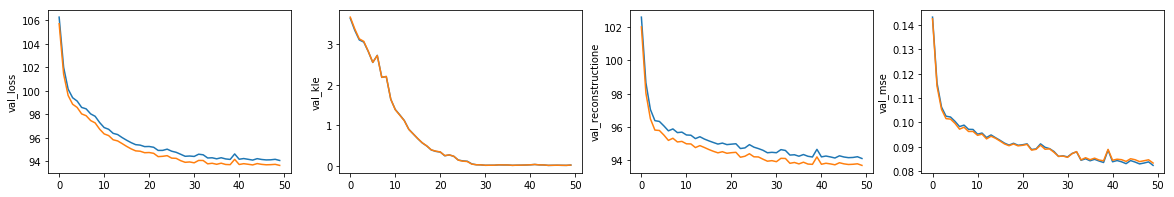

In [217]:
idx=0
mcol_lineplot2(train_his_list[idx],['loss','kle', 'reconstructione', 'mse'], n_col=4)

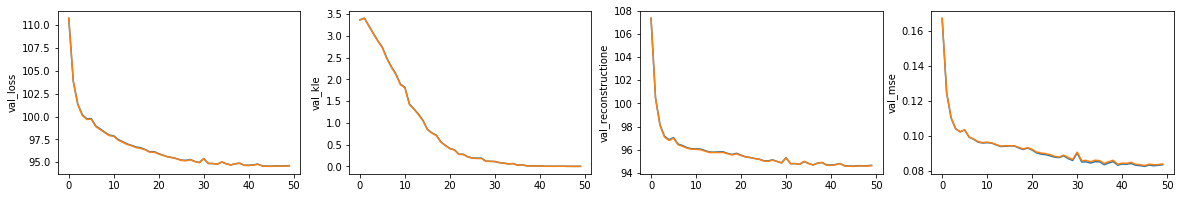

In [218]:
idx=1
mcol_lineplot2(train_his_list[idx],['loss','kle', 'reconstructione', 'mse'], n_col=4)

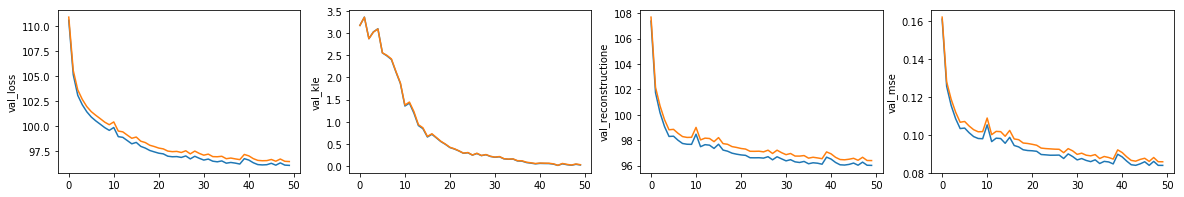

In [219]:
idx=2
mcol_lineplot2(train_his_list[idx],['loss','kle', 'reconstructione', 'mse'], n_col=4)

In [225]:
df_trial.to_pickle('../trial/vae.pickle')

In [226]:
df_valid_feats= df_trial.loc[2]['df_valid_feats']

In [228]:
df_valid_feats.to_pickle('../feats/vae.pkl')

In [230]:
df_test_feats = df_trial.loc[2]['df_test_feats']

In [242]:
df_test_feats_merged = pd.DataFrame()
df_test_feats_merged['index'] = df_test_feats['index']
for col in ['kle','loss','mse', 'reconstructione','z_0','z_1']:
    df_test_feats_merged[col] = df_test_feats[col].mean(axis=1)

In [243]:
df_test_feats_merged.to_pickle('../feats/vae_test.pkl')

In [244]:
df_test_feats_merged.head()

,index,kle,loss,mse,reconstructione,z_0,z_1
0,seg_00030f,0.0,95.261452,0.082477,95.261452,-10.366323,-26.824343
1,seg_0012b5,0.0,95.703845,0.076205,95.703845,-13.769868,-19.796858
2,seg_00184e,0.0,97.327665,0.078336,97.327665,-7.919527,-25.157866
3,seg_003339,0.0,88.947273,0.075722,88.947273,-23.494177,-67.213036
4,seg_0042cc,0.0,93.299952,0.085176,93.299952,-16.189550,-32.110336
